# 第2部　Pythonによる時系列分析の基本

## 第5章　Pythonによる時系列分析の基本

### 分析の準備

In [68]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa

# グラフの日本語表記
from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = 'Meiryo'
# rcParams['axes.unicode_minus'] = False

# DataFrameの全角文字の出力をきれいにする
pd.set_option('display.unicode.east_asian_width', True)

In [69]:
# 表示設定
np.set_printoptions(linewidth=80)
pd.set_option('display.width', 80)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

### 飛行機乗客数データの読み込み

In [70]:
# 飛行機乗客数データの読み込み      导入一个飞机乘客数的简单 dataset
air_passengers = sm.datasets.get_rdataset("AirPassengers").data
print(air_passengers.head(3))

# 日付インデックスの作成
date_index = pd.date_range(
    start='1949-01-01', periods=len(air_passengers), freq='MS')
air_passengers.index = date_index

# 不要な時間ラベルの削除    把旧的 time 列删除掉
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

# 結果の確認
print(air_passengers.head(3))

          time  value
0  1949.000000    112
1  1949.083333    118
2  1949.166667    132
            value
1949-01-01    112
1949-02-01    118
1949-03-01    132


### 時系列折れ線グラフの作成

#### pandasのplotメソッドの利用

<Axes: >

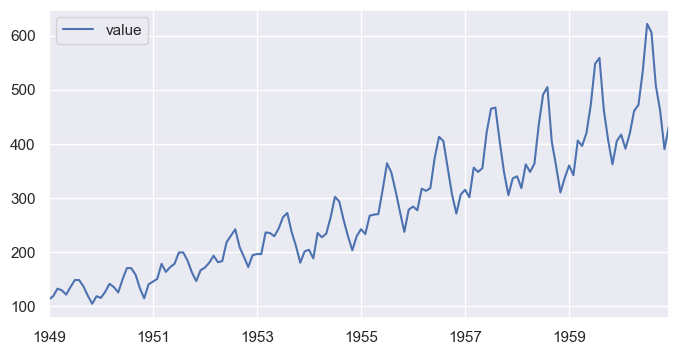

In [71]:
# 時系列折れ線グラフの作成
air_passengers.plot()

#### matplotlibとseabornの利用

/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20055 (\N{CJK UNIFIED IDEOGRAPH-4E57}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 23458 (\N{CJK UNIFIED IDEOGRAPH-5BA2}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH

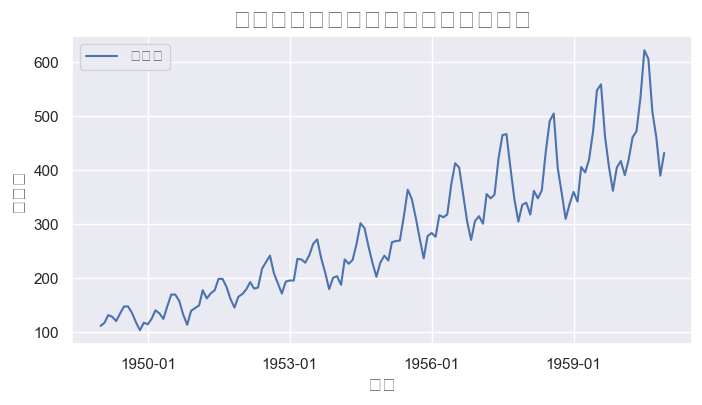

In [72]:
# グラフサイズの指定    指定图表的尺寸
fig, ax = plt.subplots(figsize=(8, 4))

# 折れ線グラフを描く    使用 value 列作为数据，图例为“原系列”
ax.plot(air_passengers['value'], label='原系列')

# 軸ラベルとタイトル・凡例
ax.set_xlabel('年月', size=14)      # x轴标签，字号为14
ax.set_ylabel('乗客数', size=14)    # y轴标签，字号为14
ax.set_title('飛行機乗客数データの折れ線グラフ', size=18)
ax.legend()

# 軸の指定
# 3年ごとに軸を載せる  设置x轴主刻度，让它每3年显示一次
# DayLocator / MonthLocator / YearLocator
ax.xaxis.set_major_locator(mdates.YearLocator(3))

# 軸ラベルのフォーマット  设置x轴刻度标签的日期格式
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

### データのシフト（ラグ）

In [73]:
# データをコピー    拷贝一份数据
air_passengers_lag = air_passengers.copy()

# シフトした結果をlag1列として追加  把value列数据向下错一行，赋给 lag1 列
# 相当于拿到“前一个月”的数据
air_passengers_lag['lag1'] = air_passengers_lag['value'].shift(1)

# 結果の確認
print(air_passengers_lag.head(3))
print(air_passengers_lag.tail(3))

            value   lag1
1949-01-01    112    NaN
1949-02-01    118  112.0
1949-03-01    132  118.0
            value   lag1
1960-10-01    461  508.0
1960-11-01    390  461.0
1960-12-01    432  390.0


In [74]:
# さまざまな次数でラグをとる
# 把value列数据向下错两行，赋给 lag2 列
air_passengers_lag['lag2'] = air_passengers_lag['value'].shift(2)
# 把value列数据向上错一行，赋给 lead1 列
air_passengers_lag['lead1'] = air_passengers_lag['value'].shift(-1)

# 結果の確認
print(air_passengers_lag.head(3))
print(air_passengers_lag.tail(3))

            value   lag1   lag2  lead1
1949-01-01    112    NaN    NaN  118.0
1949-02-01    118  112.0    NaN  132.0
1949-03-01    132  118.0  112.0  129.0
            value   lag1   lag2  lead1
1960-10-01    461  508.0  606.0  390.0
1960-11-01    390  461.0  508.0  432.0
1960-12-01    432  390.0  461.0    NaN


### 増減量と差分系列

#### 差分系列の取得

In [75]:
# 差分値をとる      计算本月与上月值的差分
diff_value = air_passengers_lag['value'] - air_passengers_lag['value'].shift(1)
diff_value.head(3)

1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
Freq: MS, Name: value, dtype: float64

In [76]:
# データをコピー
air_passengers_diff = air_passengers.copy()

# 差分系列  求一阶差分（其实就是当前值减去上一行的值）
air_passengers_diff['diff1'] = air_passengers_diff['value'].diff(1)

# 結果の確認
print(air_passengers_diff.head(3))
print(air_passengers_diff.tail(3))

            value  diff1
1949-01-01    112    NaN
1949-02-01    118    6.0
1949-03-01    132   14.0
            value  diff1
1960-10-01    461  -47.0
1960-11-01    390  -71.0
1960-12-01    432   42.0


### 前年差と季節差分系列

#### 季節差分系列

In [77]:
# 季節差分  本数据是以 12 个月为周期，所以直接向下错 12 期的值就是 今年去年的同期差值
air_passengers_diff['diff12'] = air_passengers_diff['value'].diff(12)

            value  diff1  diff12  diff12-1
1949-01-01    112    NaN     NaN       NaN
1949-02-01    118    6.0     NaN       NaN
1949-03-01    132   14.0     NaN       NaN
1949-04-01    129   -3.0     NaN       NaN
1949-05-01    121   -8.0     NaN       NaN
1949-06-01    135   14.0     NaN       NaN
1949-07-01    148   13.0     NaN       NaN
1949-08-01    148    0.0     NaN       NaN
1949-09-01    136  -12.0     NaN       NaN
1949-10-01    119  -17.0     NaN       NaN
1949-11-01    104  -15.0     NaN       NaN
1949-12-01    118   14.0     NaN       NaN
1950-01-01    115   -3.0     3.0       NaN
1950-02-01    126   11.0     8.0       5.0
1950-03-01    141   15.0     9.0       1.0
1950-04-01    135   -6.0     6.0      -3.0
1950-05-01    125  -10.0     4.0      -2.0
1950-06-01    149   24.0    14.0      10.0
1950-07-01    170   21.0    22.0       8.0
1950-08-01    170    0.0    22.0       0.0


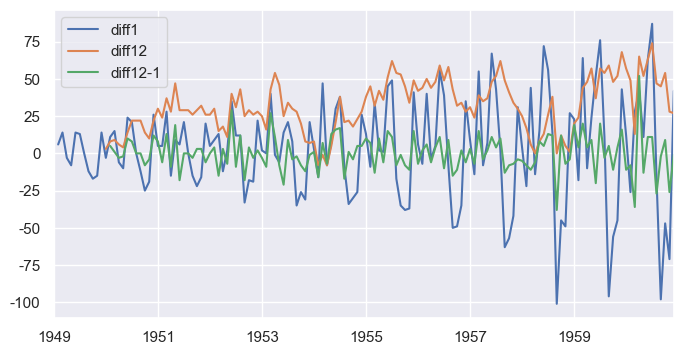

In [78]:
# 季節差分系列に対して、さらに差分をとる
air_passengers_diff['diff12-1'] = air_passengers_diff['diff12'].diff(1)

# 時系列折れ線グラフの作成
air_passengers_diff[['diff1', 'diff12', 'diff12-1']].plot()

print(air_passengers_diff.head(20))

In [79]:
# 参考：差分をとる順番は関係ない
# 对于时间序列中的“普通差分（diff(1））”和“季节差分（diff(12））”这两种操作，无论先后顺序如何，其结果在数学上是相同的。
# 即：“差分的先后顺序并不会改变最终结果”
air_passengers_diff['diff1-12'] = air_passengers_diff['diff1'].diff(12)

all(air_passengers_diff['diff12-1'].dropna() == air_passengers_diff['diff1-12'].dropna())

True

### 対数系列

#### 対数系列の取得

<Axes: >

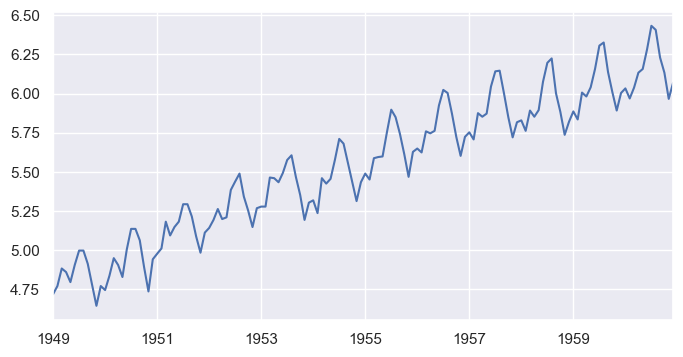

In [80]:
# データをコピー
air_passengers_log = air_passengers.copy()

# 対数変換      对 value 求自然对数值
air_passengers_log['log'] = air_passengers_log['value'].apply(np.log)

# 時系列折れ線グラフの作成
air_passengers_log['log'].plot()

In [81]:
# 対数変換をもとに戻す
air_passengers_log['log'].apply(np.exp).head(3)

1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
Freq: MS, Name: log, dtype: float64

### 増減率と対数差分系列

#### 対数差分系列と対数季節差分系列の取得

In [82]:
# 对数变换能够将指数增长的序列变得更线性
# 一阶差分（diff(1)）： 去除时间序列中的线性趋势，使序列均值或方差更为稳定
# 季节差分（diff(12)）： 去除（或减弱）年度周期重复的模式，使得序列更接近平稳
# 将二者结合起来（先对数变换，再差分），往往能得到更平稳、更适合后续建模与预测的时间序列。

# 対数差分系列
air_passengers_log['log_diff1'] = air_passengers_log['log'].diff(1)

# 対数季節差分系列
air_passengers_log['log_diff12'] = air_passengers_log['log'].diff(12)

<Axes: >

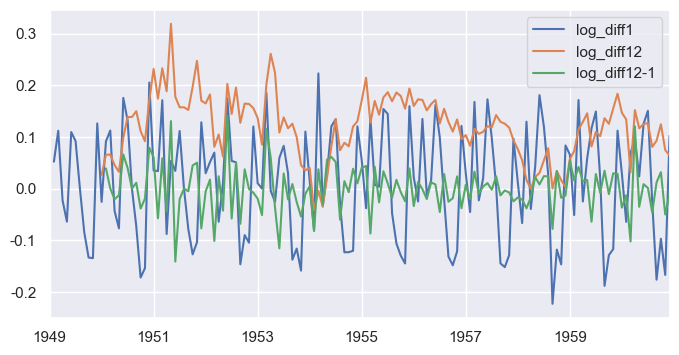

In [83]:
# 対数季節差分系列に対して、さらに差分をとる
air_passengers_log['log_diff12-1'] = air_passengers_log['log_diff12'].diff(1)

# 時系列折れ線グラフの作成
air_passengers_log[['log_diff1', 'log_diff12', 'log_diff12-1']].plot()

### 自己相関係数とコレログラム

#### 自己相関係数とコレログラム

什么是自相关函数（ACF）？

自相关：指的是同一序列在不同时间点之间的相关程度，也就是说，时间序列某一时刻的值与之前（或之后）若干时刻的值相似或关联的程度。
ACF：是将不同滞后（lag）下的自相关系数集中列出的函数，它对于分析时间序列是否存在周期性、趋势性等特征非常有帮助。

In [84]:
# 自己相関係数  acf（Autocorrelation Function，自相关函数）
# nlags 用于控制“最多计算到第几阶滞后（lag）”
# 例如：滞后 12 就代表 $𝑥_𝑡$ 与 $x_t−12$（前 12 个时刻）的相关性。
tsa.acf(air_passengers['value'], nlags=12)

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542, 0.71376997,
       0.6817336 , 0.66290439, 0.65561048, 0.67094833, 0.70271992, 0.74324019,
       0.76039504])

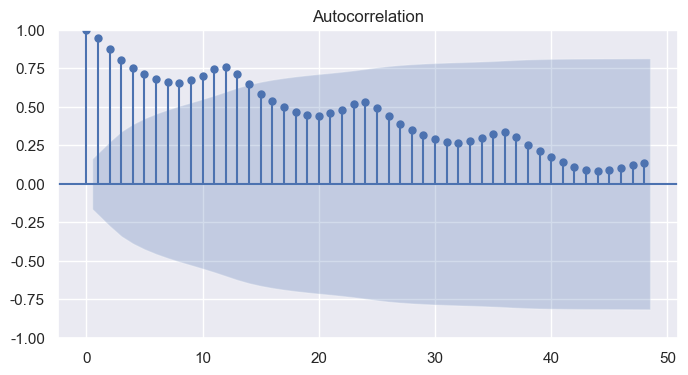

In [85]:
# コレログラム
_ = sm.graphics.tsa.plot_acf(air_passengers['value'], lags=48)

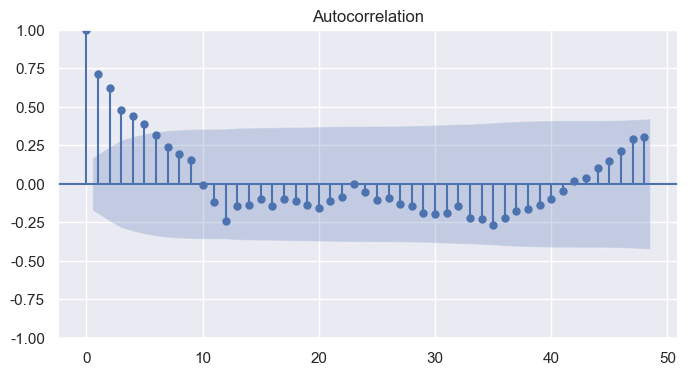

In [86]:
# 対数差分系列のコレログラム
# 1. 选择对数差分12期的序列，并去除 NaN    2. 滞后阶数设置为 48
_ = sm.graphics.tsa.plot_acf(
    air_passengers_log['log_diff12'].dropna(), lags=48)

#### 自己相関のイメージ

<Axes: xlabel='value', ylabel='value'>

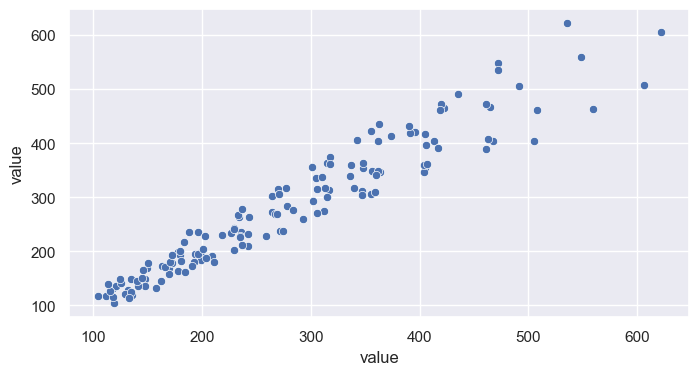

In [87]:
# 正の自己相関のイメージ
# x 轴：上个月的乘客数    y 轴：本月的乘客数
# 如果散点分布倾向于从左下角到右上角呈上升趋势，说明当上一个月的乘客数较高时，本月的乘客数也往往较高；当上一个月的乘客数较低时，本月的乘客数也往往较低。这就体现了“正相关”
sns.scatterplot(x=air_passengers['value'].shift(1), 
                y=air_passengers['value'])

<Axes: xlabel='log_diff12', ylabel='log_diff12'>

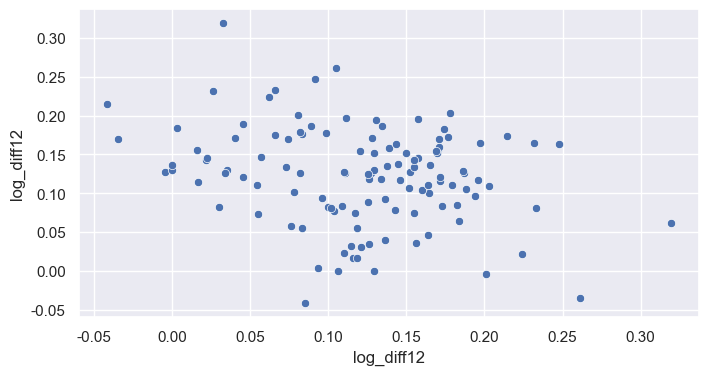

In [88]:
# 参考：負の自己相関のイメージ
# 如果散点图大部分点呈 左上到右下的分布（负斜率），说明当一年前（滞后 12）差分值较大时，现在这期（当前）的差分值往往较低，反之亦然。这就是一种负相关的体现：过去数值增高，对当前数值可能有抑制或反向影响。
sns.scatterplot(x=air_passengers_log['log_diff12'].shift(12), 
                y=air_passengers_log['log_diff12'])

#### 偏自己相関係数

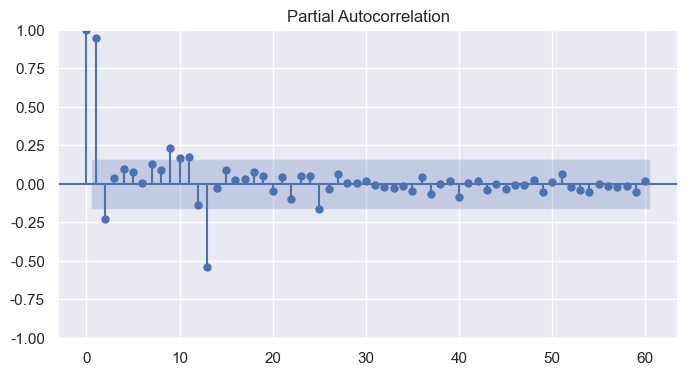

In [89]:
# 偏自己相関係数のコレログラム
# 只想看“x_t与 𝑥_{t−k} 的直接关系”，不想让中间的那些滞后值“夹在中间” 传递影响，就会用到 偏自相关。排除了中间滞后带来的间接影响。
_ = sm.graphics.tsa.plot_pacf(air_passengers['value'], lags=60, method='ywm')

### 移動平均

In [90]:
# データをコピー
air_passengers_ma = air_passengers.copy()

# 5時点の移動平均
# 以窗口大小为 5 的方式，对 value 列做“滚动计算”求窗口内平均值
air_passengers_ma['ma5'] = air_passengers_ma['value'].rolling(
    window=5).mean()

# 5時点の移動平均において、当該時点を中心にする
# 以窗口大小为 5 ，当前点为中心点，对 value 列做“滚动计算”求窗口内平均值
air_passengers_ma['ma5_center'] = air_passengers_ma['value'].rolling(
    window=5, center=True).mean()

# 結果の確認
print(air_passengers_ma.head(6))

            value    ma5  ma5_center
1949-01-01    112    NaN         NaN
1949-02-01    118    NaN         NaN
1949-03-01    132    NaN       122.4
1949-04-01    129    NaN       127.0
1949-05-01    121  122.4       133.0
1949-06-01    135  127.0       136.2


### 偶数個の移動平均の注意点

#### 通常の4時点移動平均の問題

In [91]:
# 4時点移動平均
air_passengers_ma['ma4_center'] = air_passengers_ma['value'].rolling(
    window=4, center=True).mean()

print(air_passengers_ma[['value', 'ma4_center']].head(4))
print(air_passengers_ma[['value', 'ma4_center']].tail(4))

            value  ma4_center
1949-01-01    112         NaN
1949-02-01    118         NaN
1949-03-01    132      122.75
1949-04-01    129      125.00
            value  ma4_center
1960-09-01    508      549.25
1960-10-01    461      491.25
1960-11-01    390      447.75
1960-12-01    432         NaN


#### 正しい重みづけ

In [92]:
# 加重平均の重み    设定权重
weight = np.concatenate([np.array([1/8]), np.tile(1/4, 3), np.array([1/8])])
weight

array([0.125, 0.25 , 0.25 , 0.25 , 0.125])

In [93]:
# 1949年3月の加重移動平均値
# 从 1949 年 1 月到 1949 年 5 月的 5 条数据中，按照一组指定的权重来求加权平均
np.average(air_passengers_ma['value'].loc['1949-01':'1949-05'],
           weights=weight)

123.875

In [94]:
# 加重平均をまとめて計算
# 在滚动窗口中，按照自定义的权重，计算窗口内的加权平均值
true_ma4 = air_passengers_ma['value'].rolling(
    window=5, center=True).apply(np.average, kwargs={'weights': weight})
true_ma4.head(5)

1949-01-01        NaN
1949-02-01        NaN
1949-03-01    123.875
1949-04-01    127.125
1949-05-01    131.250
Freq: MS, Name: value, dtype: float64

#### 中心化移動平均の効率的な実装

In [95]:
# 単純な4月移動平均に対して、さらに移動平均をとる
# 对 4点居中平均的平滑序列，再做“2点移动平均”（平滑序列，减少短期振动），再将结果提前一行（在索引上更好的反映“中间位置”的值）
# 这种操作在“经典的时间序列平滑和季节性分解”中很常见，帮助我们获得更稳定更有代表性的“中心时刻”数值平滑曲线
air_passengers_ma['true_ma4'] = \
    air_passengers_ma['ma4_center'].rolling(window=2).mean().shift(-1)

print(air_passengers_ma.head(4))
print(air_passengers_ma.tail(4))

            value  ma5  ma5_center  ma4_center  true_ma4
1949-01-01    112  NaN         NaN         NaN       NaN
1949-02-01    118  NaN         NaN         NaN       NaN
1949-03-01    132  NaN       122.4      122.75   123.875
1949-04-01    129  NaN       127.0      125.00   127.125
            value    ma5  ma5_center  ma4_center  true_ma4
1960-09-01    508  548.6       517.4      549.25    520.25
1960-10-01    461  546.4       479.4      491.25    469.50
1960-11-01    390  517.4         NaN      447.75       NaN
1960-12-01    432  479.4         NaN         NaN       NaN


In [96]:
# 参考：2つの方法で求めた中心化移動平均の比較
# 对一个布尔值做平方运算，可以转化为 0 或 1 的值，是一种常用技巧
np.all((air_passengers_ma['true_ma4'].dropna() == true_ma4.dropna())**2)

True

#### 12時点中心化移動平均

说明：为什么要进行两次平滑并 shift？
第一次：12 个月居中平均：能平滑掉大多数的月度波动。但只做一次居中平均，对于奇数窗口没有问题，对于偶数窗口需要再做一次 2 点平均来确定最佳对齐位置（因为偶数段上没有真正的“中点”）
第二次：2 点平均+向前移动：对偶数窗口居中平均后，会产生一个相对“中间”的值并分布在两个时间点之间。再做一次 2 点平均，并把结果向上移1 行，可以对准更合适的时间索引，取得更精确的平滑曲线

<Axes: >

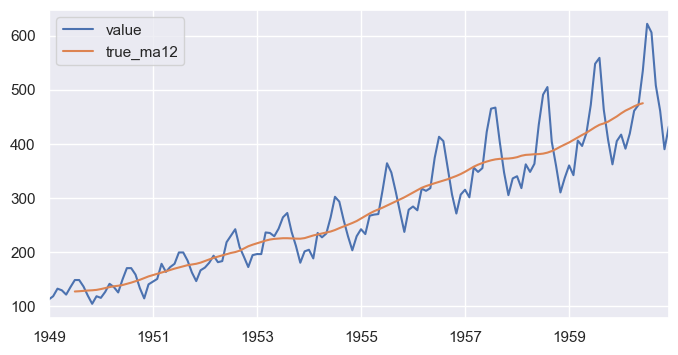

In [97]:
# 12時点移動平均    12 点居中平均
air_passengers_ma['ma12_center'] = air_passengers_ma['value'].rolling(
    window=12, center=True).mean()

# 単純な12月移動平均に対して、さらに移動平均をとる
# これが中心化移動平均となる
# 在进行二次平滑（2 点平均并向上移动一格）
air_passengers_ma['true_ma12'] = \
    air_passengers_ma['ma12_center'].rolling(window=2).mean().shift(-1)

# 原系列と12時点移動平均の比較
air_passengers_ma[['value', 'true_ma12']].plot()

### 月次の気温データの分析例
https://www.data.jma.go.jp/risk/obsdl/index.php

In [98]:
# CSVファイルの読み込み
# 在读入数据的时候，就可以设定并解析时间 index
weather_month = pd.read_csv(
    '2-5-1-weather-month.csv',
    index_col='年月',
    parse_dates=True,
    dtype='float'
)

# 頻度の指定    月度频率
weather_month.index.freq = 'MS'

# 最初と最後の3行の表示
print(weather_month.head(3))
print(weather_month.tail(3))

            平均気温(℃)  日最高気温35℃以上日数(日)
年月                                              
1900-01-01          1.6                        0.0
1900-02-01          3.1                        0.0
1900-03-01          5.7                        0.0
            平均気温(℃)  日最高気温35℃以上日数(日)
年月                                              
2021-10-01         18.2                        0.0
2021-11-01         13.7                        0.0
2021-12-01          7.9                        0.0


<Axes: xlabel='年月'>

/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEO

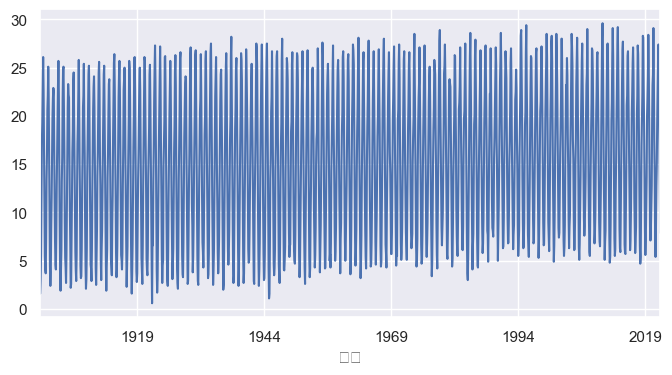

In [99]:
weather_month['平均気温(℃)'].plot()

### データの取得頻度の変更

#### 1年間における35℃以上の日数

In [100]:
# 1年における35℃以上日数の取得
# 将月度统计数据重采样到按年统计（求和）
weather_year = weather_month.resample('YS').sum()

# 不要な列の削除    删除不需要的列
weather_year = weather_year.drop('平均気温(℃)', axis=1)

# 結果の確認
print(weather_year.head(3))
print(weather_year.tail(3))

            日最高気温35℃以上日数(日)
年月                                 
1900-01-01                        1.0
1901-01-01                        1.0
1902-01-01                        0.0
            日最高気温35℃以上日数(日)
年月                                 
2019-01-01                       12.0
2020-01-01                       12.0
2021-01-01                        2.0


            日最高気温35℃以上日数(日)  15時点移動平均値
年月                                                   
1900-01-01                        1.0               NaN
1901-01-01                        1.0               NaN
1902-01-01                        0.0               NaN
1903-01-01                        0.0               NaN
1904-01-01                        0.0               NaN
...                               ...               ...
1995-01-01                       13.0          3.466667
1996-01-01                        2.0          3.466667
1997-01-01                        3.0          3.866667
1998-01-01                        3.0          4.000000
1999-01-01                        0.0          3.933333

[100 rows x 2 columns]


/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH

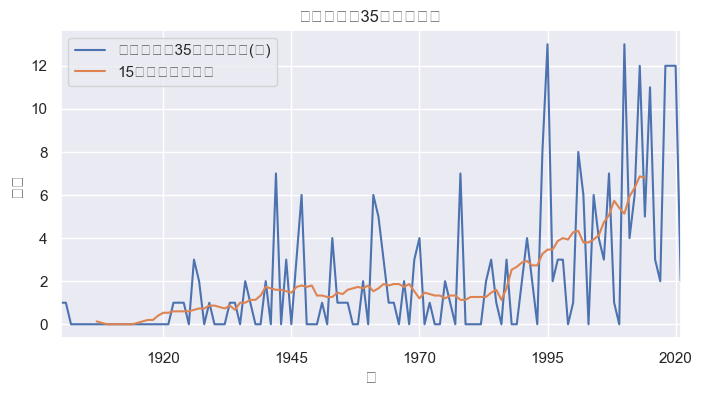

In [107]:
# 15時点移動平均    进行窗口为 15 的移动平均
weather_year['15時点移動平均値'] = \
    weather_year['日最高気温35℃以上日数(日)'].rolling(
        window=15, center=True).mean()

# 時系列折れ線グラフの作成      画出折线图
weather_year[['日最高気温35℃以上日数(日)', '15時点移動平均値']].plot(
    title='日最高気温35℃以上日数', xlabel='年', ylabel='日数')

print(weather_year.head(100))

#### 月平均気温の年間平均値

<Axes: title={'center': '月平均気温の年間平均値'}, xlabel='年', ylabel='気温(℃)'>

/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8451 (\N{DEGREE CELSIUS}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missi

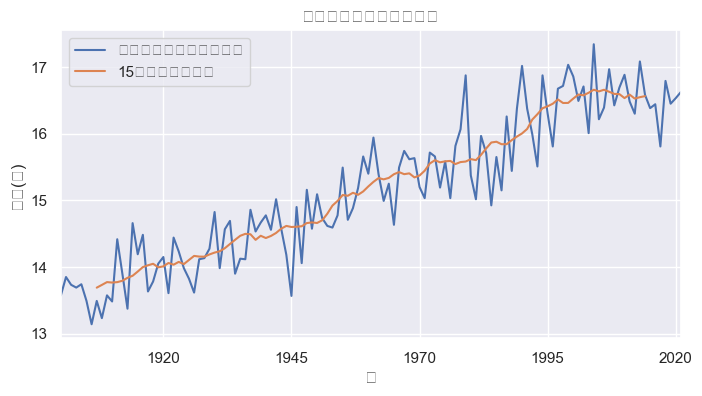

In [ ]:
# 月平均気温の年間平均値の取得
# 按年度重采样，计算年度平均值
weather_year['月平均気温の年間平均値'] = \
    weather_month['平均気温(℃)'].resample('YS').mean()

# 15時点移動平均値の取得
# 计算窗口为 15 的移动平均值
weather_year['15時点移動平均値'] = \
    weather_year['月平均気温の年間平均値'].rolling(
        window=15, center=True).mean()

# 時系列折れ線グラフの作成      绘制折线图
weather_year[['月平均気温の年間平均値', '15時点移動平均値']] .plot(
    title='月平均気温の年間平均値', xlabel='年', ylabel='気温(℃)')

#### その他の集計方法

            日最高気温35℃以上日数(日)  15時点移動平均値  \
年月                                                      
1900-01-01                        1.0               NaN   
1901-01-01                        1.0               NaN   
1902-01-01                        0.0               NaN   
1903-01-01                        0.0               NaN   
1904-01-01                        0.0               NaN   
1905-01-01                        0.0               NaN   
1906-01-01                        0.0               NaN   
1907-01-01                        0.0         24.946667   
1908-01-01                        0.0         24.920000   
1909-01-01                        0.0         24.913333   
1910-01-01                        0.0         25.100000   
1911-01-01                        0.0         25.126667   
1912-01-01                        0.0         25.120000   
1913-01-01                        0.0         25.306667   
1914-01-01                        0.0         25.360000   
1915-01-01      

/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/dongwei/opt/anaconda3/envs/time_series/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH

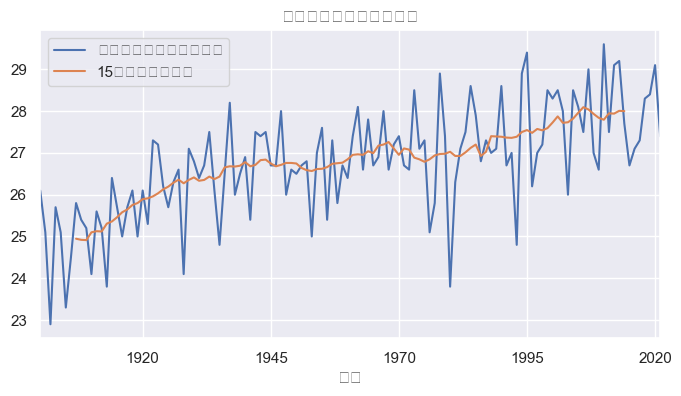

In [112]:
# 如何将月平均气温按照年度进行重采样
# 参考

# 月平均気温の年間最大値の取得
weather_year['月平均気温の年間最大値'] = weather_month['平均気温(℃)'].resample('YS').max()

# 15時点移動平均値の取得
weather_year['15時点移動平均値'] = weather_year['月平均気温の年間最大値'].rolling(
    window=15, center=True).mean()

# 時系列折れ線グラフの作成
weather_year[['月平均気温の年間最大値', '15時点移動平均値']].plot(title='月平均気温の年間最大値')

print(weather_year.head(20))

<Axes: title={'center': '月平均気温の年間最小値'}, xlabel='年月'>

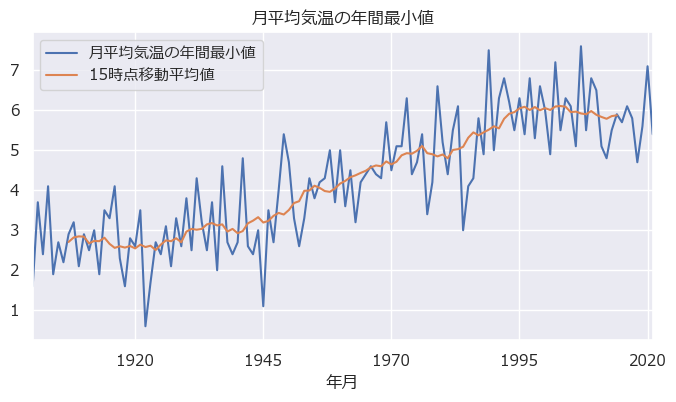

In [37]:
# 参考

# 月平均気温の年間最小値の取得
weather_year['月平均気温の年間最小値'] = weather_month['平均気温(℃)'].resample('YS').min()

# 15時点移動平均値の取得
weather_year['15時点移動平均値'] = weather_year['月平均気温の年間最小値'].rolling(
    window=15, center=True).mean()

# 時系列折れ線グラフの作成
weather_year[['月平均気温の年間最小値', '15時点移動平均値']] .plot(title='月平均気温の年間最小値')